In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [40]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [41]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=3)

In [43]:
class MNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]  
        image = np.array(row.iloc[1:], dtype=np.uint8).reshape(28, 28, 1)
        label = row.iloc[0]  
        if self.transform:
            image = self.transform(image)
        return image, label

    def plot_image(self, idx):
        image, label = self.__getitem__(idx)
        image = image.numpy().squeeze()  
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')  
        plt.show()


In [44]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [45]:
batch_size = 32

train_dataset = MNISTDataset(train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_dataset = MNISTDataset(validation_df, transform=transform)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

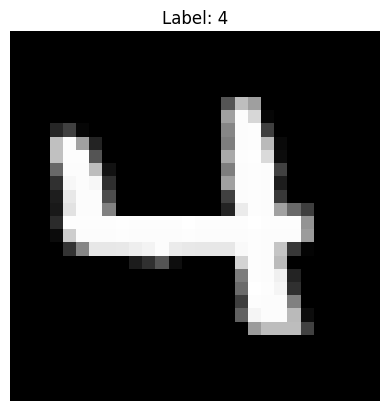

In [46]:
train_dataset.plot_image(0) 

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
class DigitNet(nn.Module):
    def __init__(self):
        super(DigitNet, self).__init__()
        # First block of convolutions and pooling
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 

        # Second block of convolutions and pooling
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Correcting the number of input channels for conv6
        self.conv6 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(192 * 3 * 3, 256) 
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool2(x)
        x = F.relu(self.conv6(x))
        x = self.pool3(x)

        # Flatten the output for the dense layer
        x = torch.flatten(x, 1)
        
        # Fully connected layers with ReLU activation for the first
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer with logits output, no activation
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = DigitNet().to(device)
print(net)

DigitNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1728, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [49]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0)  

n_epochs = 12

In [53]:
for epoch in range(n_epochs):
    # Training loop with tqdm
    net.train()
    train_losses = []
    train_correct = 0  # To keep track of correct predictions

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Training")):
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()
        pred = net(images)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_correct += (pred.argmax(1) == labels).sum().item()  

    train_accuracy = train_correct / len(train_loader.dataset)
    avg_train_loss = sum(train_losses) / len(train_losses)

    # Validation loop with tqdm
    net.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            pred = net(images)
            val_loss += loss_fn(pred, labels).item()
            val_correct += (pred.argmax(1) == labels).sum().item()

    validation_accuracy = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss / len(val_loader)

    # Print training and validation results
    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Training Accuracy = {train_accuracy * 100:.2f}%, Average Loss = {avg_train_loss:.4f}")
    print(f"Validation Accuracy = {validation_accuracy * 100:.2f}%, Average Loss = {avg_val_loss:.4f}")


Validating: 100%|██████████| 263/263 [00:04<00:00, 54.23it/s]


Epoch 1/12
Training Accuracy = 99.29%, Average Loss = 0.0237
Validation Accuracy = 98.00%, Average Loss = 0.0613


Validating: 100%|██████████| 263/263 [00:04<00:00, 56.01it/s]


Epoch 2/12
Training Accuracy = 99.37%, Average Loss = 0.0194
Validation Accuracy = 98.44%, Average Loss = 0.0526


Validating: 100%|██████████| 263/263 [00:04<00:00, 54.96it/s]


Epoch 3/12
Training Accuracy = 99.49%, Average Loss = 0.0170
Validation Accuracy = 98.43%, Average Loss = 0.0495


Validating: 100%|██████████| 263/263 [00:04<00:00, 53.51it/s]


Epoch 4/12
Training Accuracy = 99.60%, Average Loss = 0.0142
Validation Accuracy = 98.44%, Average Loss = 0.0506


Validating: 100%|██████████| 263/263 [00:04<00:00, 53.69it/s]


Epoch 5/12
Training Accuracy = 99.69%, Average Loss = 0.0111
Validation Accuracy = 98.18%, Average Loss = 0.0632


Validating: 100%|██████████| 263/263 [00:04<00:00, 54.07it/s]


Epoch 6/12
Training Accuracy = 99.72%, Average Loss = 0.0101
Validation Accuracy = 98.25%, Average Loss = 0.0675


Validating: 100%|██████████| 263/263 [00:04<00:00, 54.25it/s]


Epoch 7/12
Training Accuracy = 99.73%, Average Loss = 0.0091
Validation Accuracy = 98.48%, Average Loss = 0.0542


Validating: 100%|██████████| 263/263 [00:04<00:00, 53.61it/s]


Epoch 8/12
Training Accuracy = 99.77%, Average Loss = 0.0074
Validation Accuracy = 98.71%, Average Loss = 0.0504


Validating: 100%|██████████| 263/263 [00:04<00:00, 54.43it/s]


Epoch 9/12
Training Accuracy = 99.83%, Average Loss = 0.0057
Validation Accuracy = 98.55%, Average Loss = 0.0542


Validating: 100%|██████████| 263/263 [00:04<00:00, 54.22it/s]


Epoch 10/12
Training Accuracy = 99.89%, Average Loss = 0.0048
Validation Accuracy = 98.62%, Average Loss = 0.0540


Validating: 100%|██████████| 263/263 [00:04<00:00, 55.40it/s]


Epoch 11/12
Training Accuracy = 99.89%, Average Loss = 0.0041
Validation Accuracy = 98.43%, Average Loss = 0.0598


Validating: 100%|██████████| 263/263 [00:04<00:00, 54.52it/s]

Epoch 12/12
Training Accuracy = 99.94%, Average Loss = 0.0025
Validation Accuracy = 98.61%, Average Loss = 0.0579


In [54]:
# Evaluate and get predictions with classification report
y_pred, y_true = [], []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        y_pred.extend(outputs.argmax(dim=1).tolist())
        y_true.extend(labels.tolist())

print(classification_report(y_true, y_pred))

Evaluating: 100%|██████████| 263/263 [00:04<00:00, 53.70it/s]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       806
           1       1.00      0.99      0.99       886
           2       0.98      0.99      0.98       810
           3       0.99      0.98      0.98       860
           4       0.98      0.99      0.99       832
           5       0.99      0.98      0.98       790
           6       0.99      0.99      0.99       826
           7       0.99      0.99      0.99       909
           8       0.97      0.98      0.98       815
           9       0.98      0.98      0.98       866

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



In [55]:
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [56]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
class MNISTTestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Reshape the flat pixel array into 28x28 image
        image = self.dataframe.iloc[idx].values.reshape(28, 28, 1).astype(np.uint8)
        if self.transform:
            image = self.transform(image)
        return image

In [58]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Because the numpy array needs to be converted to PIL Image
    transforms.ToTensor(),    # Converts to Tensor and scales to [0,1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])


df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')


test_dataset = MNISTTestDataset(df_test, transform=test_transform)


test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Shuffle is False for test data


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()  


predictions = []

with torch.no_grad():
    for images in tqdm(test_loader, desc="Predicting"):
        images = images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())


submission = pd.DataFrame({
    'ImageId': np.arange(1, len(predictions) + 1),
    'Label': predictions
})


submission.to_csv('mnist_predictions.csv', index=False)
print("Saved predictions to 'mnist_predictions.csv'")

Predicting: 100%|██████████| 438/438 [00:09<00:00, 45.97it/s]


Saved predictions to 'mnist_predictions.csv'
